In [1]:
import os
import requests
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from arango import ArangoClient
from IPython.display import display, HTML
import json
import numpy as np
from datetime import datetime

In [7]:
ARANGO_HOST = 'arongo_host'
ARANGO_USERNAME = 'root'
ARANGO_PASSWORD = 'your password'
DB_NAME = 'database name'

# Initialize ArangoDB client
client = ArangoClient(hosts=ARANGO_HOST)

# Connect to "_system" database as root user
sys_db = client.db('_system', username=ARANGO_USERNAME, password=ARANGO_PASSWORD)

# Check if the database exists, create if it doesn't
if not sys_db.has_database(DB_NAME):
    print(f"Creating database '{DB_NAME}'...")
    sys_db.create_database(DB_NAME)
    print(f"Database '{DB_NAME}' created successfully.")
else:
    print(f"Database '{DB_NAME}' already exists.")

Database 'study_planner' already exists.


In [9]:
db = client.db(DB_NAME, username=ARANGO_USERNAME, password=ARANGO_PASSWORD)

In [11]:
# Define expected collections
collections = ['users', 'focus_sessions', 'study_schedules', 'goals', 'topics']
edge_collections = ['topic_relations']

# Check and create standard collections if they don't exist
for collection in collections:
    if not db.has_collection(collection):
        print(f"Creating collection '{collection}'...")
        db.create_collection(collection)
        print(f"Collection '{collection}' created successfully.")
    else:
        print(f"Collection '{collection}' already exists.")

# Check and create edge collections if they don't exist
for collection in edge_collections:
    if not db.has_collection(collection):
        print(f"Creating edge collection '{collection}'...")
        db.create_collection(collection, edge=True)
        print(f"Edge collection '{collection}' created successfully.")
    else:
        print(f"Edge collection '{collection}' already exists.")

# %% [markdown]
# ## 3. Initialize Collections with Sample Data

# %%
# Initialize collections
users = db.collection('users')
focus_sessions = db.collection('focus_sessions')
study_schedules = db.collection('study_schedules')
goals = db.collection('goals')
topics = db.collection('topics')
topic_relations = db.collection('topic_relations')

# Sample data initialization function
def init_sample_data():
    # Add sample users if collection is empty
    if users.count() == 0:
        print("Adding sample user...")
        users.insert({
            "user_id": "user1",
            "name": "Dula",
            "email": "dula@example.com"
        })

    # Add sample topics if collection is empty
    if topics.count() == 0:
        print("Adding sample topics...")
        sample_topics = [
            {"topic_id": "topic1", "name": "Calculus", "difficulty": 3},
            {"topic_id": "topic2", "name": "Physics", "difficulty": 4},
            {"topic_id": "topic3", "name": "Chemistry", "difficulty": 3},
            {"topic_id": "topic4", "name": "Biology", "difficulty": 2},
            {"topic_id": "topic5", "name": "Computer Science", "difficulty": 4}
        ]
        for topic in sample_topics:
            topics.insert(topic)

    # Add sample topic relations if collection is empty
    if topic_relations.count() == 0:
        print("Adding sample topic relations...")
        sample_relations = [
            {"_from": "topics/topic1", "_to": "topics/topic2", "relationship": "prerequisite"},
            {"_from": "topics/topic2", "_to": "topics/topic3", "relationship": "related"},
            {"_from": "topics/topic3", "_to": "topics/topic4", "relationship": "related"},
            {"_from": "topics/topic4", "_to": "topics/topic5", "relationship": "optional"}
        ]
        for relation in sample_relations:
            topic_relations.insert(relation)
            
    # Add sample focus sessions if collection is empty
    if focus_sessions.count() == 0:
        print("Adding sample focus sessions...")
        # Create sample focus sessions covering different days and times
        days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
        times = [9, 10, 14, 16, 18]  # Hours of the day
        topics_list = ["topic1", "topic2", "topic3", "topic4", "topic5"]
        
        # Generate sample dates - use current month but different days
        now = datetime.now()
        current_month = now.month
        current_year = now.year
        
        for day_idx, day in enumerate(days_of_week):
            for hour in times:
                # Generate a datetime for this session
                date_str = f"{current_year}-{current_month:02d}-{(day_idx+1):02d}T{hour:02d}:00:00"
                
                # Select a topic
                topic = topics_list[(day_idx + hour) % len(topics_list)]
                
                # Generate a focus score - make it higher in mornings and for certain topics
                base_score = 70
                time_bonus = 10 if hour < 12 else 0  # Morning bonus
                topic_bonus = 10 if topic in ["topic1", "topic5"] else 0  # Bonus for certain topics
                day_penalty = 0 if day in ["Monday", "Wednesday"] else 5  # Better focus on certain days
                
                focus_score = min(95, max(50, base_score + time_bonus + topic_bonus - day_penalty))
                
                # Random duration between 30-60 minutes
                duration = np.random.randint(30, 61)
                focused_time = int(duration * (focus_score / 100))
                
                # Create the session document
                session = {
                    "user_id": "user1",
                    "topic": topic,
                    "start_time": date_str,
                    "total_time": duration,
                    "focused_time": focused_time,
                    "focus_score": focus_score,
                    "timestamp": datetime.now().isoformat()
                }
                
                focus_sessions.insert(session)

Collection 'users' already exists.
Collection 'focus_sessions' already exists.
Collection 'study_schedules' already exists.
Collection 'goals' already exists.
Collection 'topics' already exists.
Edge collection 'topic_relations' already exists.


In [13]:
# Call initialization function
init_sample_data()

In [15]:
# Function to retrieve data from collections
def get_collection_data(collection_name):
    """Retrieve all documents from a given collection"""
    collection = db.collection(collection_name)
    cursor = db.aql.execute(f"FOR doc IN {collection_name} RETURN doc")
    return [doc for doc in cursor]

# Retrieve data from each collection
users_data = get_collection_data('users')
topics_data = get_collection_data('topics')
relations_data = get_collection_data('topic_relations')
focus_data = get_collection_data('focus_sessions')

# Display the data
print("===== Users =====")
display(pd.DataFrame(users_data))

print("\n===== Topics =====")
display(pd.DataFrame(topics_data))

print("\n===== Topic Relations =====")
display(pd.DataFrame(relations_data))

print("\n===== Focus Sessions Sample (first 5) =====")
focus_df = pd.DataFrame(focus_data)
if not focus_df.empty:
    display(focus_df.head())
else:
    print("No focus sessions found")

===== Users =====


,_key,_id,_rev,user_id,name,email
0,497479,users/497479,_jUtiNty---,user1,Dula,nasibo.com



===== Topics =====


,_key,_id,_rev,topic_id,name,difficulty
0,497482,topics/497482,_jUtiO-----,topic1,Calculus,3
1,497484,topics/497484,_jUtiODa---,topic2,Physics,4
2,497486,topics/497486,_jUtiOKa---,topic3,Chemistry,3
3,497488,topics/497488,_jUtiOP6---,topic4,Biology,2
4,497490,topics/497490,_jUtiOVa---,topic5,Computer Science,4



===== Topic Relations =====


,_key,_id,_from,_to,_rev,relationship
0,497493,topic_relations/497493,topics/topic1,topics/topic2,_jUtiOgW---,prerequisite
1,497495,topic_relations/497495,topics/topic2,topics/topic3,_jUtiOl2---,related
2,497497,topic_relations/497497,topics/topic3,topics/topic4,_jUtiOrW---,related
3,497499,topic_relations/497499,topics/topic4,topics/topic5,_jUtiOw2---,optional



===== Focus Sessions Sample (first 5) =====


,_key,_id,_rev,user_id,start_time,end_time,focus_score,focused_time,total_time,topic,is_active,timestamp,id,peak_focus,focus_data
0,546902,focus_sessions/546902,_jU9Cjki---,67b88d6a40ca1cefbf8e8a31,2025-03-07T08:41:42.968Z,2025-03-07T08:41:42.968Z,0.0,0,0,Study Session,True,2025-03-07T11:41:43.525408,NaN,NaN,NaN
1,547066,focus_sessions/547066,_jU9EWEe---,67b88d6a40ca1cefbf8e8a31,2025-03-07T08:43:40.456Z,2025-03-07T08:43:40.456Z,0.0,0,0,Study Session,True,2025-03-07T11:43:40.775120,NaN,NaN,NaN
2,547409,focus_sessions/547409,_jU9K_V----,67b88d6a40ca1cefbf8e8a31,2025-03-07T08:49:50.345Z,2025-03-07T08:49:50.345Z,0.0,0,0,Study Session,True,2025-03-07T11:49:50.667144,NaN,NaN,NaN
3,547529,focus_sessions/547529,_jU9LMFu---,user1,2025-03-07T08:51:08.705Z,2025-03-07T08:51:08.705Z,0.0,0,0,Study Session,True,2025-03-07T11:51:09.290330,NaN,NaN,NaN
4,547549,focus_sessions/547549,_jU9Llv----,user1,2025-03-07T08:51:35.243Z,2025-03-07T08:51:35.243Z,0.0,0,0,Study Session,True,2025-03-07T11:51:35.566555,NaN,NaN,NaN


In [17]:
# Analyze focus sessions if data exists
if focus_data:
    # Convert focus sessions to DataFrame for analysis
    focus_df = pd.DataFrame(focus_data)
    
    # Basic statistics
    print("===== Focus Session Stats =====")
    if 'focus_score' in focus_df.columns:
        print(f"Average Focus Score: {focus_df['focus_score'].mean():.2f}")
    if 'total_time' in focus_df.columns:
        print(f"Total Study Time: {focus_df['total_time'].sum()} minutes")
    if 'focused_time' in focus_df.columns:
        print(f"Total Focused Time: {focus_df['focused_time'].sum()} minutes")
        if focus_df['total_time'].sum() > 0:
            print(f"Overall Focus Efficiency: {focus_df['focused_time'].sum() / focus_df['total_time'].sum() * 100:.2f}%")
    

===== Focus Session Stats =====
Average Focus Score: 26.05
Total Study Time: 261 minutes
Total Focused Time: 204 minutes
Overall Focus Efficiency: 78.16%



===== Topic Focus Scores =====


topic
hackathon        33.33500
Study Session    28.07386
chemistry         0.00000
computer          0.00000
tropical          0.00000
Name: focus_score, dtype: float64

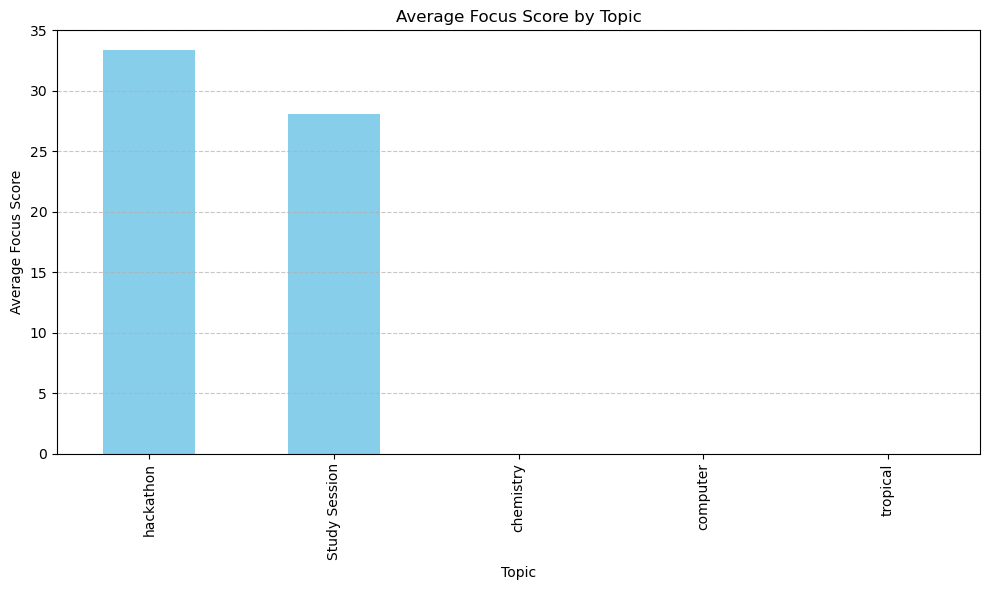

In [21]:
# Topic analysis if data exists
if 'topic' in focus_df.columns and 'focus_score' in focus_df.columns:
        topic_focus = focus_df.groupby('topic')['focus_score'].mean().sort_values(ascending=False)
        print("\n===== Topic Focus Scores =====")
        display(topic_focus)
        
        # Plot topic focus scores
        plt.figure(figsize=(10, 6))
        topic_focus.plot(kind='bar', color='skyblue')
        plt.title('Average Focus Score by Topic')
        plt.xlabel('Topic')
        plt.ylabel('Average Focus Score')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

In [31]:
# Time analysis if data exists
if 'start_time' in focus_df.columns and 'focus_score' in focus_df.columns:
        # Parse start times if they are strings
        if focus_df['start_time'].dtype == 'object':
            focus_df['datetime'] = pd.to_datetime(focus_df['start_time'])
        
        # Extract day and hour
        focus_df['day'] = focus_df['datetime'].dt.day_name()
        focus_df['hour'] = focus_df['datetime'].dt.hour
        
        # Analyze focus by day
        day_focus = focus_df.groupby('day')['focus_score'].mean().reindex([
            'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
        ], fill_value=0)
    

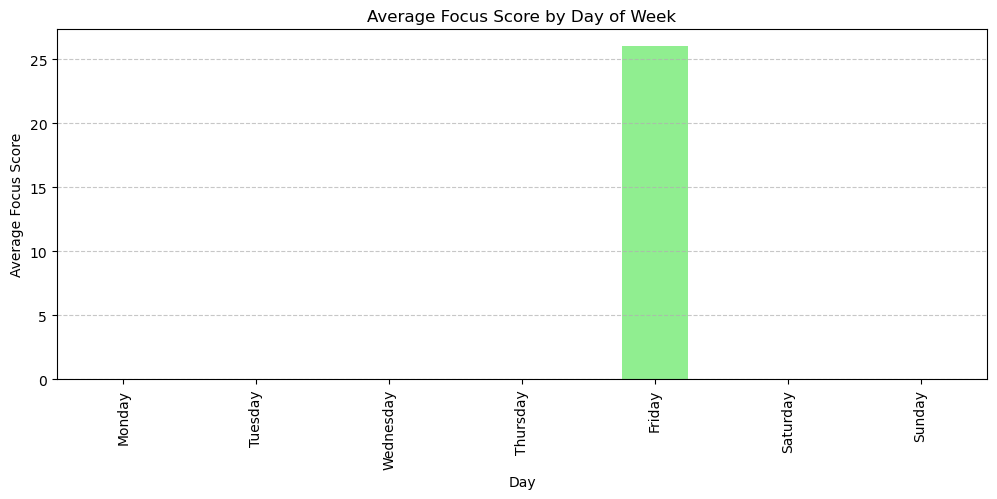

In [41]:
# Analyze focus by hour
hour_focus = focus_df.groupby('hour')['focus_score'].mean()
        
# Plot focus by day
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
day_focus.plot(kind='bar', color='lightgreen')
plt.title('Average Focus Score by Day of Week')
plt.xlabel('Day')
plt.ylabel('Average Focus Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)


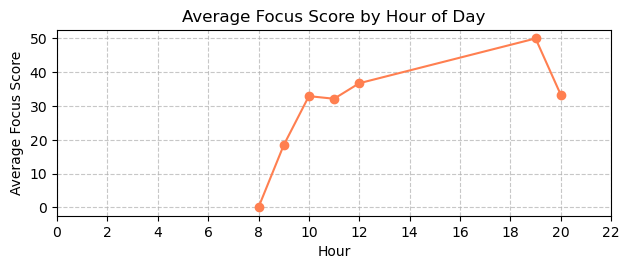

In [45]:
 plt.subplot(2, 1, 2)
hour_focus.plot(kind='line', marker='o', color='coral')
plt.title('Average Focus Score by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Focus Score')
plt.xticks(range(0, 24, 2))
plt.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [51]:
# Create focus heatmap if data exists
if focus_data and 'start_time' in focus_df.columns and 'focus_score' in focus_df.columns:
    # Ensure we have day and hour columns
    if 'day' not in focus_df.columns or 'hour' not in focus_df.columns:
        focus_df['datetime'] = pd.to_datetime(focus_df['start_time'])
        focus_df['day'] = focus_df['datetime'].dt.day_name()
        focus_df['hour'] = focus_df['datetime'].dt.hour
    
    # Create pivot table for heatmap
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
     # Filter to only include days and hours with data
    available_days = focus_df['day'].unique()
    heatmap_days = [d for d in days_order if d in available_days]
    
    # Create pivot table with hours as columns and days as rows
    pivot_data = focus_df.pivot_table(
        values='focus_score', 
        index='day', 
        columns='hour',
        aggfunc='mean'
    ).reindex(heatmap_days)

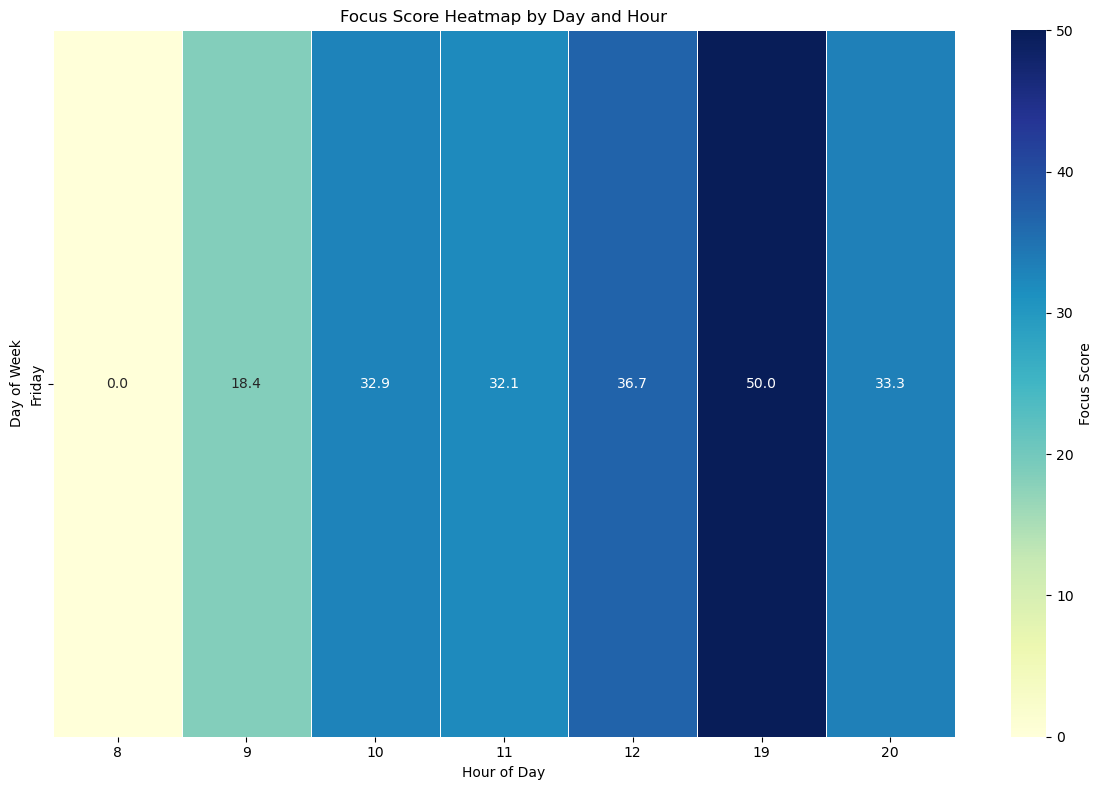

In [55]:
# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_data, 
    cmap='YlGnBu', 
    annot=True, 
    fmt='.1f',
    linewidths=.5,
    cbar_kws={'label': 'Focus Score'}
)
plt.title('Focus Score Heatmap by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

In [59]:
 # Find optimal study times
if not pivot_data.empty:
        # Find top 3 best times to study
        # Flatten the pivot table and sort
        flat_pivot = pivot_data.stack().reset_index()
        flat_pivot.columns = ['day', 'hour', 'focus_score']
        top_times = flat_pivot.sort_values('focus_score', ascending=False).head(3)
        
        print("===== Optimal Study Times =====")
        for idx, row in top_times.iterrows():
            print(f"{row['day']} at {int(row['hour']):02d}:00 - Average Focus Score: {row['focus_score']:.1f}")
else:
    print("No focus session data available for heatmap creation.")

===== Optimal Study Times =====
Friday at 19:00 - Average Focus Score: 50.0
Friday at 12:00 - Average Focus Score: 36.7
Friday at 20:00 - Average Focus Score: 33.3


In [69]:
# Create and visualize the knowledge graph if data exists
if topics_data and relations_data:
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes (topics)
    for topic in topics_data:
        G.add_node(
            topic['topic_id'], 
            name=topic['name'], 
            difficulty=topic.get('difficulty', 3)
        )
        # Add edges (relationships)
    for relation in relations_data:
        from_topic = relation['_from'].split('/')[1]
        to_topic = relation['_to'].split('/')[1]
        relationship = relation.get('relationship', 'related')
        G.add_edge(from_topic, to_topic, relationship=relationship)
    
    # Plot the graph
    plt.figure(figsize=(12, 8))
    # Define node positions using spring layout

<Figure size 1200x800 with 0 Axes>

In [73]:
# Define node positions using spring layout
pos = nx.spring_layout(G, seed=42)

# Get node difficulties for node size
difficulties = [G.nodes[node].get('difficulty', 3) for node in G.nodes()]
node_sizes = [d * 100 + 200 for d in difficulties]  # Scale difficulty for visualization

# Get node names for labels
node_labels = {node: G.nodes[node]['name'] for node in G.nodes()}

# Define edge styles based on relationship
edge_styles = {
    'prerequisite': 'solid',
    'related': 'dashed',
    'optional': 'dotted'
}

{'topic1': Text(-0.8238391610010021, -0.25047079776193887, 'Calculus'),
 'topic2': Text(-0.5682154018326923, 0.09905641878756173, 'Physics'),
 'topic3': Text(-0.08452540609888799, 0.17619504175509149, 'Chemistry'),
 'topic4': Text(0.47657996893258286, 0.05894762251030648, 'Biology'),
 'topic5': Text(1.0, -0.08372828529102082, 'Computer Science')}

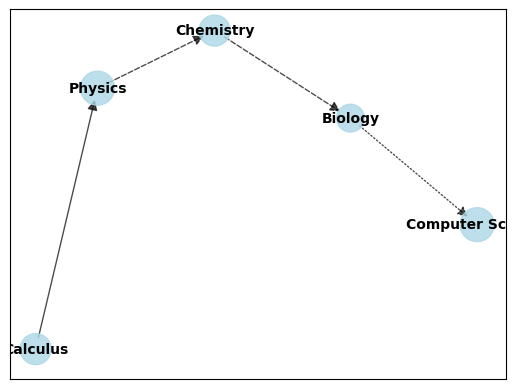

In [75]:
# Draw nodes
nx.draw_networkx_nodes(
    G, pos, 
    node_size=node_sizes,
    node_color='lightblue',
    alpha=0.8
)

# Draw edges with different styles
for relationship, style in edge_styles.items():
    edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('relationship') == relationship]
    nx.draw_networkx_edges(
        G, pos,
        edgelist=edges,
        style=style,
        alpha=0.7,
        arrows=True,
        arrowsize=15
    )

# Draw labels
nx.draw_networkx_labels(
    G, pos,
    labels=node_labels,
    font_size=10,
    font_weight='bold'
)

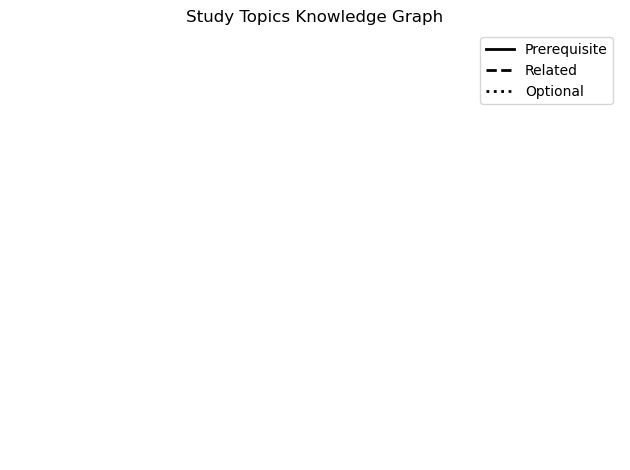

In [79]:
# Create legend for edge types
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', lw=2, linestyle='solid', label='Prerequisite'),
    Line2D([0], [0], color='black', lw=2, linestyle='dashed', label='Related'),
    Line2D([0], [0], color='black', lw=2, linestyle='dotted', label='Optional')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.title('Study Topics Knowledge Graph')
plt.axis('off')
plt.tight_layout()
plt.show()

In [87]:
# Generate an optimal study schedule based on analysis
if focus_data and 'focus_score' in focus_df.columns:
    # Ensure we have all the data we need
    if 'topic' not in focus_df.columns or 'day' not in focus_df.columns or 'hour' not in focus_df.columns:
        # Extract needed information if missing
        if 'start_time' in focus_df.columns:
            focus_df['datetime'] = pd.to_datetime(focus_df['start_time'])
            focus_df['day'] = focus_df['datetime'].dt.day_name()
            focus_df['hour'] = focus_df['datetime'].dt.hour
    
    # Get best day-hour combinations
    day_hour_scores = focus_df.groupby(['day', 'hour'])['focus_score'].mean().reset_index()
    top_times = day_hour_scores.sort_values('focus_score', ascending=False).head(10)
     # Get best topic performances
    topic_scores = focus_df.groupby('topic')['focus_score'].mean().sort_values(ascending=False)
    schedule = []
    
    scheduled_topics = set()

In [95]:
print("===== Summary and Recommendations =====")

if focus_data:
    # Find patterns in the data
    best_topics = []
    best_days = []
    best_times = []
    
    if 'topic' in focus_df.columns and 'focus_score' in focus_df.columns:
        topic_focus = focus_df.groupby('topic')['focus_score'].mean().sort_values(ascending=False)
        if not topic_focus.empty:
            best_topic_id = topic_focus.index[0]
            best_topic_name = next((t['name'] for t in topics_data if t['topic_id'] == best_topic_id), best_topic_id)
            best_topics.append(best_topic_name)
    
    if 'day' in focus_df.columns and 'focus_score' in focus_df.columns:
        day_focus = focus_df.groupby('day')['focus_score'].mean().sort_values(ascending=False)
        if not day_focus.empty:
            best_days = day_focus.index[:2].tolist()  # Top 2 days
    
    if 'hour' in focus_df.columns and 'focus_score' in focus_df.columns:
        hour_focus = focus_df.groupby('hour')['focus_score'].mean().sort_values(ascending=False)
        if not hour_focus.empty:
            best_hours = hour_focus.index[:3].tolist()  # Top 3 hours
            best_times = [f"{int(hour):02d}:00" for hour in best_hours]
    
    # Generate recommendations
    print("Based on your focus session data, here are some recommendations:")
    
    if best_topics:
        print(f"\n1. Topic Strength: You perform best in {', '.join(best_topics)}.")
        print("   Consider starting your study sessions with these topics when tackling difficult material.")
    
    if best_days:
        print(f"\n2. Optimal Days: Your focus is highest on {' and '.join(best_days)}.")
        print("   Schedule your most challenging topics on these days.")
    
    if best_times:
        print(f"\n3. Optimal Times: Your peak focus hours are at {', '.join(best_times)}.")
        print("   Try to align your most difficult study sessions with these times.")
    
    if 'total_time' in focus_df.columns and 'focused_time' in focus_df.columns:
        efficiency = focus_df['focused_time'].sum() / focus_df['total_time'].sum() * 100
        if efficiency < 70:
            print("\n4. Focus Improvement: Your overall focus efficiency is below optimal levels.")
            print("   Consider techniques like the Pomodoro method (25 min study, 5 min break) to improve focus.")
        else:
            print("\n4. Focus Strength: Your focus efficiency is good. Keep up the good work!")
    
    # Generate graph-based recommendations if we have topic relations
    if topics_data and relations_data:
        # Check if we built the graph earlier
        if 'G' not in locals():
            # Create graph
            G = nx.DiGraph()
            for topic in topics_data:
                G.add_node(topic['topic_id'], name=topic['name'], difficulty=topic.get('difficulty', 3))
            for relation in relations_data:
                from_topic = relation['_from'].split('/')[1]
                to_topic = relation['_to'].split('/')[1]
                relationship = relation.get('relationship', 'related')
                G.add_edge(from_topic, to_topic, relationship=relationship)
        
        # Find prerequisite chains
        prereq_chains = []
        for u, v, data in G.edges(data=True):
            if data.get('relationship') == 'prerequisite':
                prereq_chains.append((G.nodes[u]['name'], G.nodes[v]['name']))
        
        if prereq_chains:
            print("\n5. Learning Path Recommendations:")
            for prereq, topic in prereq_chains:
                print(f"   - Master {prereq} before proceeding to {topic}")
else:
    print("Not enough data available for personalized recommendations.")
    print("Try logging more focus sessions to get better insights!")

===== Summary and Recommendations =====
Based on your focus session data, here are some recommendations:

1. Topic Strength: You perform best in hackathon.
   Consider starting your study sessions with these topics when tackling difficult material.

2. Optimal Days: Your focus is highest on Friday.
   Schedule your most challenging topics on these days.

3. Optimal Times: Your peak focus hours are at 19:00, 12:00, 20:00.
   Try to align your most difficult study sessions with these times.

4. Focus Strength: Your focus efficiency is good. Keep up the good work!

5. Learning Path Recommendations:
   - Master Calculus before proceeding to Physics
